# Tutorial: Using DFtoVW and exploring VW output

---

The purpose of this tutorial is to show how to use the `DFtoVW` class to convert a pandas's DataFrame into a list of Vowpal Wabbit examples and to explore the outputs (model weights, VW output log) of the trained model. The VW output log is parsed using the class `VWLogParser` defined in this notebook.

The task is to predict the concentration of [particulate matter](https://en.wikipedia.org/wiki/Particulates) (more specifically PM 2.5) in the atmosphere of 5 chinese cities. The original dataset contained 19 columns (targets, datetime and atmospheric features) and 167 358 observations.
- For more details on the data, see the following UCI repository: https://archive.ics.uci.edu/ml/datasets/PM2.5+Data+of+Five+Chinese+Cities
- For the associated academic papers, see [Liang, Xuan, et al. "PM2. 5 data reliability, consistency, and air quality assessment in five Chinese cities."](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2016JD024877) and [Liang, Xuan, et al. "Assessing Beijing's PM2. 5 pollution: severity, weather impact, APEC and winter heating."](https://royalsocietypublishing.org/doi/10.1098/rspa.2015.0257)

The data can be download from the following URL: https://archive.ics.uci.edu/ml/machine-learning-databases/00394/FiveCitiePMData.rar. A function `download_data` is available in this notebook to download and extract the data (but this step can be done manually if desired). The folder is containing the data is defined using the constant variable `DATA_FOLDER` and is `'PM_DATA'` by default.

### Notebook outline

**1. Data**

**2. Train a first model**

**3. Visualizing model outputs**

**4. Train a more complex model: using log transformed target and namespace interactions**


### Requirements

The notebook was developed for VW 8.11.0.

It should work with older versions (>= 8.10) except for one cell in section 4.3 where the attribute `name` of `Feature` is accessed.

---


### Importing packages/modules

In [1]:
import os
from os.path import join
import re

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from vowpalwabbit.DFtoVW import DFtoVW
from vowpalwabbit.pyvw import vw

### Defining functions/class


In [2]:
# Data import/download functions
def download_data(dest_dir="PM_DATA"):
    import requests
    from io import BytesIO
    from rarfile import RarFile
    
    URL_PM_CITIES = "https://archive.ics.uci.edu/ml/machine-learning-databases/00394/FiveCitiePMData.rar"

    print(f"Downloading data at {URL_PM_CITIES}")
    r = requests.get(URL_PM_CITIES)
    bcontent = BytesIO(r.content)
    rf = RarFile(bcontent)
    
    print(f"Extracting content in folder {repr(dest_dir)}")
    rf.extractall(dest_dir)

def import_pm_city_data(folder_path, verbose=True):
    df_lst = []
    for fname in os.listdir(folder_path):
        fpath = join(folder_path, fname)
        if verbose:
            print(f"Importing file: {fpath}")
        city_name = re.sub("pm$", repl="", string=re.search("^[a-z]+", string=fname.lower()).group())
        
        df_city = pd.read_csv(fpath)
        df_city_clean = (df_city
                         .assign(city=city_name)
                         .drop(columns=["No"] + [col for col in df_city.columns if ("PM" in col) and (col != "PM_US Post")])
                         .rename(columns={"PM_US Post": "PM"})
                         .dropna(subset=["PM"])
        )
        df_lst += [df_city_clean]
    
    df_city = (
        pd.concat(df_lst) # append dataframes
        .sample(frac=1, random_state=123) # shuffle
        .reset_index(drop=True)
    )
    
    return df_city

# VW output parsing function/class
class VWLogParser:
    """Parser for Vowpal Wabbit output log/diagnostic"""
    
    def __init__(self, file_path_or_list):
        """The file name or list of lines to parse"""
        if isinstance(file_path_or_list, (list, str)):
            self.file_path_or_list = file_path_or_list
        else:
            raise TypeError("Argument `fname` should be a str (for file path) or a list of log lines")
    
    def parse(self):
        """Parse the output from `vw` command, return dataframe/dictionnaries with the associated data."""
        # Init containers 
        self.table_lst = []
        self.params = {}
        self.metrics = {}

        self.inside_table = False
        self.after_table = False
        
        if isinstance(self.file_path_or_list, list):
            for row in self.file_path_or_list:
                self._parse_vw_row(row)
        else:
            with open(self.file_path_or_list, "r") as f:
                for row in f:
                    self._parse_vw_row(row)
            

        self.df = self._make_output_df(self.table_lst)

        return self.params, self.df, self.metrics

    def _cast_string(self, s):
        """Cast to float or int if possible"""
        try:
            out = float(s)
        except ValueError:
            out = s
        else:
            if out.is_integer():
                out = int(out)

        return out

    def _make_output_df(self, lst):
        """Make dataframe from the list"""
        # Make columns from first and second elements of the list
        columns = [f"{first_row}_{second_row}" for (first_row, second_row) in zip(*lst[:2])]

        df = pd.DataFrame(data=lst[2:], columns=columns)

        # Cast cols to appropriate types
        int_cols = ["example_counter", "current_features"]
        for col in int_cols:
            df[col] = df[col].astype(int)

        float_cols = df.columns.drop(int_cols)
        for col in float_cols:
            df[col] = df[col].astype(float)

        return df

    def _parse_vw_row(self, row):
        """Parse row and add parsed elements to instance attributes params, metrics and table_lst"""
        if "=" in row:
            param_name, value = [element.strip() for element in row.split("=", maxsplit=1)]
            if self.after_table:
                self.metrics[param_name] = self._cast_string(value)
            else:
                self.params[param_name] = self._cast_string(value)
        elif ":" in row:
            param_name, value = [element.strip() for element in row.split(":", maxsplit=1)]
            self.params[param_name] = self._cast_string(value)

        elif not self.after_table:
            if re.match("average\s+since", row):
                self.inside_table = True
            if row == "\n":
                self.inside_table = False
                self.after_table = True
            if self.inside_table:
                self.table_lst += [row.split()]


# Model weight inspection functions                
def get_feature_names(df):
    cat_names = get_cat_feature_names(df)
    num_names = df.select_dtypes(np.number).columns.tolist()
    
    return cat_names + num_names


def get_cat_feature_names(df):
    unique_values_cat = df.select_dtypes(object).apply(lambda s: s.dropna().unique())
    cat_names = [f"{key}={value}" 
                 for (key, unique_values) in unique_values_cat.items()
                 for value in unique_values
    ]
    
    return cat_names


def get_weight_from_name(model, feature_name, namespace_name=" "):
    space_hash = model.hash_space(namespace_name)
    feat_hash = model.hash_feature(feature_name, space_hash)
    return model.get_weight(feat_hash)

### Constants

In [3]:
# Data
DATA_FOLDER = "PM_DATA"

# Graphical
SUPTITLE_FONTSIZE = 20
SUPTITLE_FONTWEIGHT = "bold"
TITLE_FONTSIZE = 15

---

# 1. Data

## 1.1. Import

In [4]:
if not (os.path.isdir(DATA_FOLDER) and len(os.listdir(DATA_FOLDER)) == 5):
    download_data(DATA_FOLDER)

df_city = import_pm_city_data(DATA_FOLDER)

df_city.head()

Importing file: PM_DATA/ShanghaiPM20100101_20151231.csv
Importing file: PM_DATA/ShenyangPM20100101_20151231.csv
Importing file: PM_DATA/ChengduPM20100101_20151231.csv
Importing file: PM_DATA/GuangzhouPM20100101_20151231.csv
Importing file: PM_DATA/BeijingPM20100101_20151231.csv


,year,month,day,hour,season,PM,DEWP,HUMI,PRES,TEMP,cbwd,Iws,precipitation,Iprec,city
0,2011,9,27,2,3.0,226.0,13.0,87.00,1017.0,15.000000,SE,41.13,0.0,0.000000,beijing
1,2013,6,26,2,2.0,51.0,17.0,82.89,1000.0,20.000000,SE,1.00,8.8,10.900000,shenyang
2,2013,11,16,19,3.0,102.0,5.0,48.03,1019.0,16.000000,SW,3.00,0.0,0.000000,shanghai
3,2015,5,20,16,1.0,13.0,0.0,14.00,1012.0,30.000000,NW,4.92,0.0,0.000000,beijing
4,2015,5,9,15,1.0,7.0,22.1,91.00,1000.0,23.700001,SE,1.70,1.5,35.700001,guangzhou


The full label of some features (the non obvious one):

- PM: PM2.5 concentration (ug/m^3)
- DEWP: Dew Point (Celsius Degree)
- TEMP: Temperature (Celsius Degree)
- HUMI: Humidity (%)
- PRES: Pressure (hPa)
- cbwd: Combined wind direction
- Iws: Cumulated wind speed (m/s)
- precipitation: hourly precipitation (mm)
- Iprec: Cumulated precipitation (mm)

## 1.2. Types

The types of the columns:

In [5]:
df_city.dtypes

year               int64
month              int64
day                int64
hour               int64
season           float64
PM               float64
DEWP             float64
HUMI             float64
PRES             float64
TEMP             float64
cbwd              object
Iws              float64
precipitation    float64
Iprec            float64
city              object
dtype: object

Some columns of the dataframe, such as `year`, `month`, `day`, `hour`, have been imported as integer type but **should be treated as categorical** by the model. Hence, we convert these columns to categorical (`str`) type.

In [6]:
to_cat_cols = ["year", "month", "day", "hour", "season"]

for col in to_cat_cols:
    df_city[col] = df_city[col].astype(str)

# Pandas converts np.nan to "nan" when casting to object/str :-(
df_city[df_city == "nan"] = np.nan

Also, we standardize the numerical variables so we can compare their weights.

In [7]:
for col in df_city.select_dtypes(np.number).columns.difference(["PM", "log_PM"]):
    df_city[col] = (df_city[col] - df_city[col].mean()) / df_city[col].std()

## 1.3. Highly correlated features

The most correlated (> 0.99) variable(s):

In [8]:
(df_city.corr()
 .reset_index().melt(id_vars="index")
 .loc[lambda df: df["index"] < df["variable"]] # since corr matrix is symetrical
 .loc[lambda df: (0.99 < df.value) & (df.value != 1)]
)

,index,variable,value
55,Iprec,precipitation,0.999998


We drop the `Iprec` variable as it is almost perfectly correlated with the `precipitation` variable.

In [9]:
df_city.drop(columns=["Iprec"], inplace=True)

# 2. Train a first model

## 2.1. Converting pandas's DataFrame to Vowpal Wabbit input format.

We now use `DFtoVW` class to convert this dataframe to a suitable VW input format. 

There are 2 usages for the class `DFtoVW`:
- **Basic usage**, using the `DFtoVW.from_colnames` convenience method.
- **Advanced usage**, that relies on the VW input format specification (see: https://github.com/VowpalWabbit/vowpal_wabbit/wiki/Input-format) and is build upon classes such as `Feature`, `Namespace` or `SimpleLabel`, `MulticlassLabel` etc..

The current section illustrates the basic usage. Section 4 will present the advanced usage.

To use the `DFtoVW.from_colnames` method: the user provides the target name as a string (`y`), the features as a list of string (`x`) and the dataframe (`df`) that has to be converted to the method. The user can also specify the type of label (argument `label_type`, default being `simple_label` for the regression). This call will build a `DFtoVW` object. 

To get the actual examples (as a list), the user call the `convert_df` method.

In [10]:
y = "PM"
x = ['year', 'month', 'day', 'hour', 'season', 'DEWP', 'HUMI', 'PRES', 'TEMP', 'cbwd', 'Iws', 'precipitation', 'city']

print("label:", y)
print("features:", x)

converter = DFtoVW.from_colnames(df=df_city, y=y, x=x)
examples = converter.convert_df()

label: PM
features: ['year', 'month', 'day', 'hour', 'season', 'DEWP', 'HUMI', 'PRES', 'TEMP', 'cbwd', 'Iws', 'precipitation', 'city']


We can inspect the first few examples:

In [11]:
examples[:5]

['226.0 | year=2011 month=9 day=27 hour=2 season=3.0 DEWP:0.08959465332461863 HUMI:0.3882591675380959 PRES:0.33023244897304604 TEMP:-0.09454293289813515 cbwd=SE Iws:0.3992336466478102 precipitation:-0.0025309449430064965 city=beijing',
 '51.0 | year=2013 month=6 day=26 hour=2 season=2.0 DEWP:0.16859123637869186 HUMI:0.3127123038886084 PRES:-1.3551226813011634 TEMP:0.3627977627323019 cbwd=SE Iws:-0.4485512843970286 precipitation:0.001016342077488344 city=shenyang',
 '102.0 | year=2013 month=11 day=16 hour=19 season=3.0 DEWP:-0.06839851278352785 HUMI:-0.32805744472967246 PRES:0.5285095231229531 TEMP:-0.003074793772047733 cbwd=SW Iws:-0.4062993566100942 precipitation:-0.0025309449430064965 city=shanghai',
 '13.0 | year=2015 month=5 day=20 hour=16 season=1.0 DEWP:-0.1671442416011194 HUMI:-0.9535707707618039 PRES:-0.16546023640172142 TEMP:1.277479153993176 cbwd=NW Iws:-0.36573750593463716 precipitation:-0.0025309449430064965 city=beijing',
 '7.0 | year=2015 month=5 day=9 hour=15 season=1.0 

For categorical features, we see that VW format is `feature_name=feature_value` whereas for numerical feature the format is `feature_name:feature_value`. One nice property of the class is that it will build the appropriate VW type (numerical or categorical) based on the pandas's column type.

Also note that:
- for categorical variables, VW adds `:1` behind the scene. For instance `day=14` is equivalent to `day=14:1`
- The `=` doesn't have any special meaning and another symbol could have been used. However it's quite standard to use `=`

Finally, if the feature name provided by the user is not found of the dataframe, the class will raise a `ValueError`:

In [12]:
try:
    DFtoVW.from_colnames(df=df_city, y=y, x=["TEMP", "COLUMN_NOT_IN_DF"])
except Exception as e:
    print(type(e))
    print(e)

<class 'ValueError'>
In 'Feature': column(s) 'COLUMN_NOT_IN_DF' not found in dataframe.


## 2.2. Define and train model

We now define the VW model. Note that we enable logging and also set the progress parameter (`-P`) to 1 to log the information _for each iteration_.

In [13]:
model = vw(P=1, enable_logging=True)

for ex in examples:
    model.learn(ex)

model.finish()

# 3. Visualizing model outputs

## 3.1. Retrieving model's parameters, losses/predictions and summary metrics from the log

Since we enable logging in the model definition (subsection 2.2), we can inspect the model's log. We use the class `VWLogParser` defined above.

The log is returned as a list of strings by the `vw.get_log` method. Below is the first 20 lines:

In [14]:
model.get_log()[:20]

['Num weight bits = 18\n',
 'learning rate = 0.5\n',
 'initial_t = 0\n',
 'power_t = 0.5\n',
 'using no cache\n',
 'Reading datafile = \n',
 'num sources = 1\n',
 'Enabled reductions: gd, scorer\n',
 'average  since         example        example  current  current  current\n',
 'loss     last          counter         weight    label  predict features\n',
 '51076.000000 51076.000000            1            1.0 226.0000   0.0000       14\n',
 '26838.500000 2601.000000            2            2.0  51.0000   0.0000       14\n',
 '21342.025716 10349.077148            3            3.0 102.0000   0.2696       14\n',
 '16048.769287 169.000000            4            4.0  13.0000   0.0000       14\n',
 '12846.064875 35.247227            5            5.0   7.0000   1.0631       14\n',
 '10843.260626 829.239380            6            6.0  30.0000   1.2035       14\n',
 '9308.463007 99.677292            7            7.0  11.0000   1.0161       14\n',
 '11939.431742 30356.212891            8      

The class `VWLogParser` parses the following log information:
- the parameters (in the first lines)
- the information available at each iteration (in our case since `P=1`)
- the summary metrics at the end of the log

The parsed information is stored in objects (`dict` and `DataFrame`) that can be easily manipulated.

In [15]:
log_parser = VWLogParser(model.get_log())
params, df_iter, summary_metrics = log_parser.parse()

In [16]:
print("Model's parameters")
display(params)
print("\n")

print("Information at each iteration")
display(df_iter)
print("\n")

print("Summary metrics")
display(summary_metrics)

Model's parameters


{'Num weight bits': 18,
 'learning rate': 0.5,
 'initial_t': 0,
 'power_t': 0.5,
 'Reading datafile': '',
 'num sources': 1,
 'Enabled reductions': 'gd, scorer'}



Information at each iteration


,average_loss,since_last,example_counter,example_weight,current_label,current_predict,current_features
0,51076.000000,51076.000000,1,1.0,226.0,0.0000,14
1,26838.500000,2601.000000,2,2.0,51.0,0.0000,14
2,21342.025716,10349.077148,3,3.0,102.0,0.2696,14
3,16048.769287,169.000000,4,4.0,13.0,0.0000,14
4,12846.064875,35.247227,5,5.0,7.0,1.0631,14
...,...,...,...,...,...,...,...
167353,4165.421788,978.738098,167354,167354.0,42.0,73.2848,14
167354,4165.402167,881.800232,167355,167355.0,110.0,80.3049,14
167355,4165.395757,3092.619873,167356,167356.0,27.0,82.6113,14
167356,4165.377903,1177.436157,167357,167357.0,27.0,61.3138,14




Summary metrics


{'number of examples': 167358,
 'weighted example sum': 167358,
 'weighted label sum': 12331595,
 'average loss': 4165.371186,
 'best constant': 73.683929,
 'total feature number': 2336281}

## 3.2. Visualizing losses across iterations + distribution of selected metrics

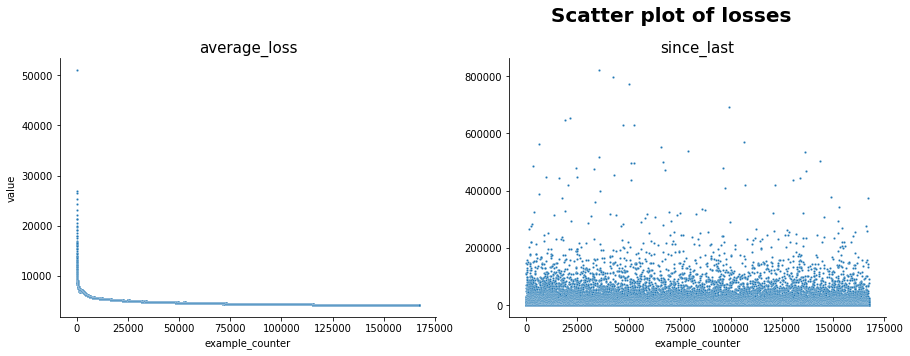

In [18]:
scatter_var = ["average_loss", "since_last"]
g = sns.relplot(data=df_iter[scatter_var + ["example_counter"]].melt(id_vars="example_counter"), 
                x="example_counter", y="value", col="variable",
                col_wrap=3, facet_kws={'sharey': False, 'sharex': True}, kind="scatter", s=5, height=5, aspect=1.25)
g.fig.suptitle('Scatter plot of losses', fontsize=SUPTITLE_FONTSIZE, fontweight=SUPTITLE_FONTWEIGHT)
g.set_titles("{col_name}", size=TITLE_FONTSIZE)
g.fig.tight_layout()

In the sections that follow, we consider the metrics for iterations after 50 000. Before this threshold, the average loss is too high.

In [19]:
start_idx = 50_000

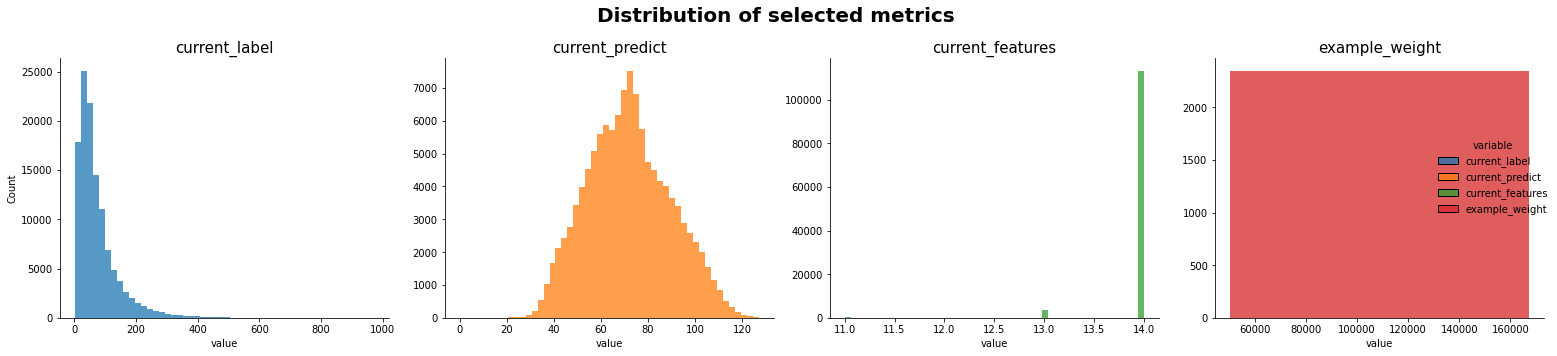

In [20]:
distr_vars = ["current_label", "current_predict", "current_features", "example_weight"]

g = sns.displot(data=df_iter.loc[start_idx:, distr_vars].melt(), 
                x="value", col="variable", multiple="dodge", hue="variable", bins=50,
                common_bins=False, facet_kws=dict(sharex=False, sharey=False), col_wrap=4, height=5)
g.fig.suptitle('Distribution of selected metrics', fontsize=SUPTITLE_FONTSIZE, fontweight=SUPTITLE_FONTWEIGHT)
g.set_titles("{col_name}", size=TITLE_FONTSIZE)
g.fig.tight_layout()

We notice that the distribution of the predictions differs substantially from the one of the labels. 

## 3.3. Visualizing the predictions of the model

This section offers a visualization of the model's predictions and compares them with the labels (the truth). 

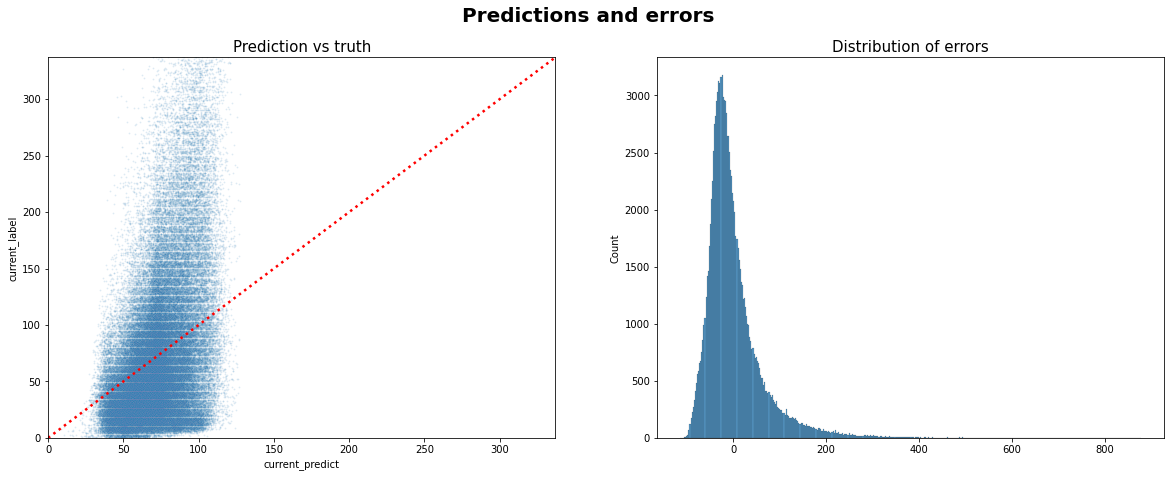

In [21]:
error = df_iter.current_label - df_iter.current_predict

f, (ax1, ax2) = plt.subplots(figsize=(20, 7), ncols=2)
f.suptitle('Predictions and errors', fontsize=SUPTITLE_FONTSIZE, fontweight=SUPTITLE_FONTWEIGHT)

# Scatterplot pred vs truth
sns.scatterplot(data=df_iter.loc[start_idx:], x="current_predict", y="current_label", ax=ax1, s=3, alpha=.15)
ax1.set_title("Prediction vs truth", fontsize=TITLE_FONTSIZE)
max_range = int(df_iter[["current_label", "current_predict"]].quantile(.99).max())
ax1.set_xlim([0, max_range])
ax1.set_ylim([0, max_range])

# Adding x=y line
#range_x = range(0, int(df_iter[["current_predict", "current_label"]].max().min()))
range_x = range(0, max_range)
ax1.plot(range_x, range_x, linestyle=":", color="red", linewidth=2.5)

# Histogram of errors
sns.histplot(error[start_idx:], ax=ax2)
ax2.set_title("Distribution of errors", fontsize=TITLE_FONTSIZE)

plt.show()


The model tends to undervalue the concentration of PM. Another way to see it is that the errors (difference between the label and the prediction) doesn't seem normally distributed (especially the right tail).

## 3.4. Visualizing learnt weights

In [22]:
# Get VW feature names
feature_names = get_feature_names(df_city)

# Get weights from feature names
weights_df = pd.DataFrame([(name, get_weight_from_name(model, name), "=" in name) for name in feature_names], 
                          columns=["vw_feature_name", "weight", "is_cat"])

# Adding columns for easier visualization
weights_df["feature_name"] = weights_df.apply(lambda row: row.vw_feature_name.split("=")[0] if row.is_cat else row.vw_feature_name, axis=1)
weights_df["feature_value"] = weights_df.apply(lambda row: row.vw_feature_name.split("=")[1].zfill(2) if row.is_cat else row.vw_feature_name, axis=1)
weights_df.sort_values(["feature_name", "feature_value"], inplace=True)

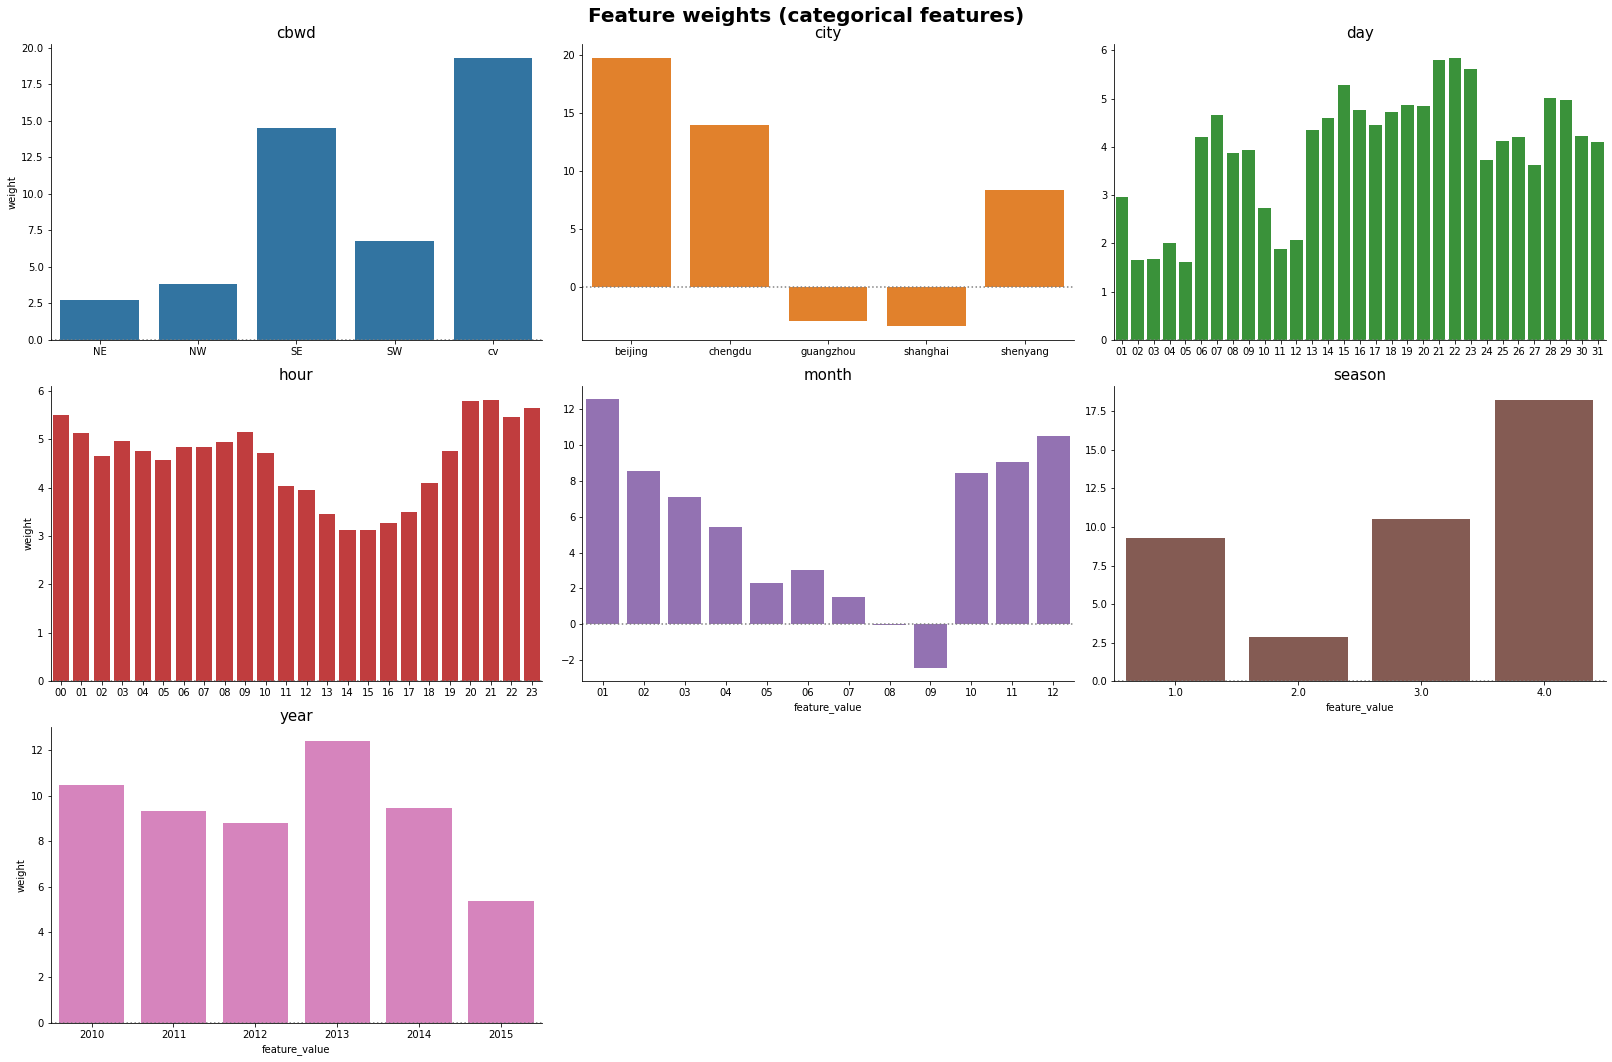

In [23]:
g = sns.catplot(data=weights_df[lambda df: df.is_cat], kind="bar", x="feature_value", y="weight", col="feature_name", hue="feature_name",
                col_wrap=3, sharex=False, sharey=False, aspect=1.5, dodge=False)
g.fig.suptitle('Feature weights (categorical features)', fontsize=SUPTITLE_FONTSIZE, fontweight=SUPTITLE_FONTWEIGHT)
g.set_titles("{col_name}", size=TITLE_FONTSIZE)

# Add horizontal bar at y=0
for ax in g.axes.flat:
    ax.axhline(0, color="gray", linestyle=":")
g.fig.tight_layout()

Based on the weights learnt by the model, the pollution will be higher:

- for wind orientation "calm and variable" (CV)
- for cities such as Beijing or Chengdu
- for winter season/months
- for certain day of month such as 21-23 (oddly)

The pollution will tend to be lower: 

- for year 2015
- for hours around noon

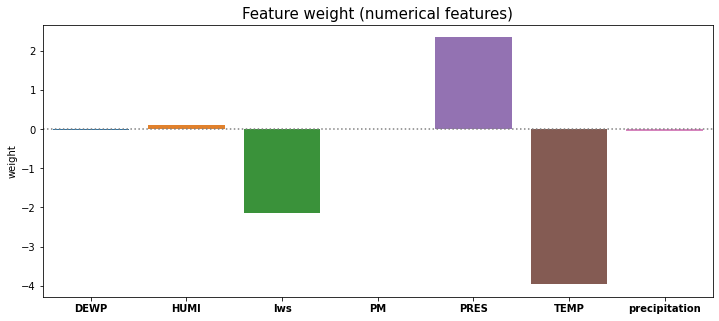

In [24]:
f, ax = plt.subplots(figsize=(12, 5))
ax = sns.barplot(data=weights_df[lambda df: df.is_cat == False], x="feature_name", y="weight")
ax.set_title("Feature weight (numerical features)", fontsize=TITLE_FONTSIZE)

# Set xlabels in bold, remove x-axis title
ax.set_xticklabels(ax.get_xticklabels(), fontweight=SUPTITLE_FONTWEIGHT)
ax.set(xlabel=None)

# Add horizontal line
ax.axhline(0, linestyle=":", color="gray")

plt.show()

Higher cumulated wind speed (Iws) and higher temperature (TEMP) are associated with lower pollution concentration. 

Higher air pressure (PRES) is associated with higher pollution concentration.

# 4. Train a more complex model: using log transformed target and namespace interactions

This section illustrates the **advanced usage** of `DFtoVW` class. To do so, we will need to import some specific classes/types from the DFtoVW module.

In [25]:
from vowpalwabbit.DFtoVW import SimpleLabel, Namespace, Feature

The following drawing explains **how to use these classes**:

<div>
<img src="DFtoVW_usage.png" align="center" width="1250"/>
</div>

## 4.1. Using log transformed variable

The distribution of the target is close to a log-normal distribution:

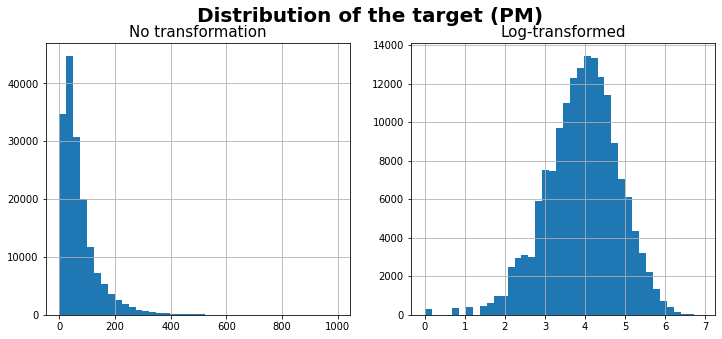

In [26]:
f, (ax1, ax2) = plt.subplots(figsize=(12, 5), ncols=2)
f.suptitle('Distribution of the target (PM)', fontsize=SUPTITLE_FONTSIZE, fontweight=SUPTITLE_FONTWEIGHT)

df_city["PM"].hist(bins=40, ax=ax1)
ax1.set_title("No transformation", fontsize=TITLE_FONTSIZE)

np.log(df_city["PM"]).hist(bins=40, ax=ax2)
ax2.set_title("Log-transformed", fontsize=TITLE_FONTSIZE)

plt.show()

We decide to train the model on the log transformation of the target (called `log_PM`). 

For regression purpose, we use `SimpleLabel` class (more details on this type on the [Input Format page](https://github.com/VowpalWabbit/vowpal_wabbit/wiki/Input-format#simple) of the wiki) to represent the target.

In [27]:
df_city["log_PM"] = df_city["PM"].apply(np.log)
label = SimpleLabel("log_PM")

## 4.2. Defining namespaces

Namespaces are defined using the `Namespace` class. They are formed with a (list of) `Feature` and can have a name.

In [28]:
# Datetime namespace
datetime_features = ["year", "month", "day", "hour", "season"]
ns_datetime = Namespace(features=[Feature(col) for col in datetime_features], name="datetime_ns")

# City namespace
ns_city = Namespace(features=Feature("city"), name="city_ns")

# Weather namespace
weather_features = df_city.columns.difference(["PM", "log_PM", "city"] + datetime_features, sort=False).tolist()
ns_weather = Namespace(features=[Feature(col) for col in weather_features], name="weather_ns")

## 4.3. Converting to VW format and training model

In [29]:
converter_advanced = DFtoVW(df=df_city, namespaces=[ns_datetime, ns_weather, ns_city], label=label)

`Namespace` and `Feature` objects can be accessed using `DFtoVW`'s instance attributes `namespaces` and `features`:

In [30]:
for namespace in converter_advanced.namespaces:
    print("namespace:", namespace.name)
    for feature in namespace.features:
        print("\tfeature:", feature.name)

namespace: datetime_ns
	feature: year
	feature: month
	feature: day
	feature: hour
	feature: season
namespace: weather_ns
	feature: DEWP
	feature: HUMI
	feature: PRES
	feature: TEMP
	feature: cbwd
	feature: Iws
	feature: precipitation
namespace: city_ns
	feature: city


We can inspect the first few examples:

In [31]:
examples_advanced = converter_advanced.convert_df()
examples_advanced[:5]

['5.420534999272286 |datetime_ns year=2011 month=9 day=27 hour=2 season=3.0 |weather_ns DEWP:0.08959465332461863 HUMI:0.3882591675380959 PRES:0.33023244897304604 TEMP:-0.09454293289813515 cbwd=SE Iws:0.3992336466478102 precipitation:-0.0025309449430064965 |city_ns city=beijing',
 '3.9318256327243257 |datetime_ns year=2013 month=6 day=26 hour=2 season=2.0 |weather_ns DEWP:0.16859123637869186 HUMI:0.3127123038886084 PRES:-1.3551226813011634 TEMP:0.3627977627323019 cbwd=SE Iws:-0.4485512843970286 precipitation:0.001016342077488344 |city_ns city=shenyang',
 '4.624972813284271 |datetime_ns year=2013 month=11 day=16 hour=19 season=3.0 |weather_ns DEWP:-0.06839851278352785 HUMI:-0.32805744472967246 PRES:0.5285095231229531 TEMP:-0.003074793772047733 cbwd=SW Iws:-0.4062993566100942 precipitation:-0.0025309449430064965 |city_ns city=shanghai',
 '2.5649493574615367 |datetime_ns year=2015 month=5 day=20 hour=16 season=1.0 |weather_ns DEWP:-0.1671442416011194 HUMI:-0.9535707707618039 PRES:-0.165460

In this new model we will add interactions between the "weather" namespace and the other namespaces

In [32]:
model_advanced = vw(arg_str="--redefine W:=weather_ns --interactions W:", P=1, enable_logging=True)

for ex in examples_advanced:
    model_advanced.learn(ex)

model_advanced.finish()

## 4.4. Visualizing model output

We transformed the labels and predictions using exponential function (since the target is log-transformed) so we can compare them with the quantities of section 3.

In [33]:
params_advanced, df_iter_advanced, metrics_advanced = VWLogParser(model_advanced.get_log()).parse()

df_iter_advanced.current_label = np.exp(df_iter_advanced.current_label)
df_iter_advanced.current_predict = np.exp(df_iter_advanced.current_predict)

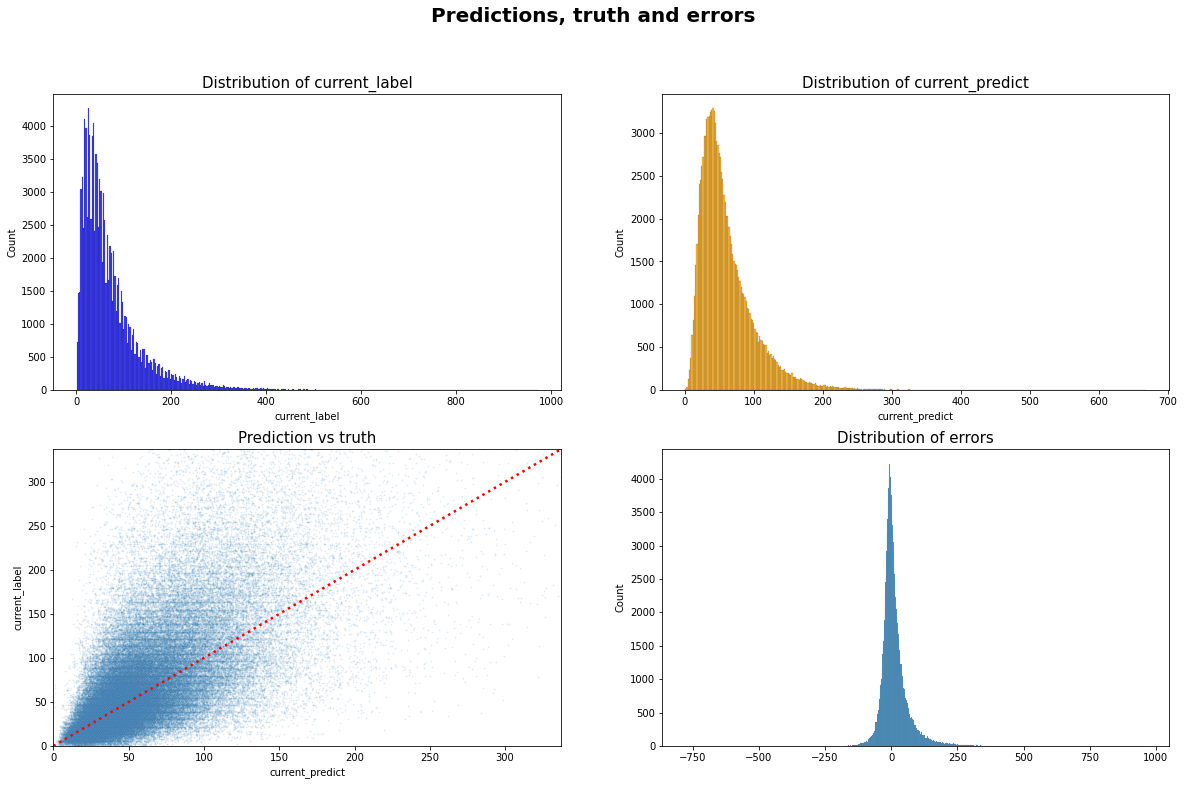

In [34]:
error_advanced = df_iter_advanced.current_label - df_iter_advanced.current_predict

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(figsize=(20, 12), ncols=2, nrows=2)
f.suptitle('Predictions, truth and errors', fontsize=SUPTITLE_FONTSIZE, fontweight=SUPTITLE_FONTWEIGHT)

sns.histplot(df_iter_advanced.current_label.iloc[start_idx:], ax=ax1, color="blue")
ax1.set_title("Distribution of current_label", fontsize=TITLE_FONTSIZE)

sns.histplot(df_iter_advanced.current_predict.iloc[start_idx:], ax=ax2, color="orange")
ax2.set_title("Distribution of current_predict", fontsize=TITLE_FONTSIZE)

sns.scatterplot(data=df_iter_advanced.iloc[start_idx:], 
                x="current_predict", y="current_label", ax=ax3, s=3, alpha=.15)
ax3.set_title("Prediction vs truth", fontsize=TITLE_FONTSIZE)

# Add x=y line
max_range = int(df_iter[["current_label", "current_predict"]].quantile(.99).max())
ax3.set_xlim(0, max_range)
ax3.set_ylim(0, max_range)
range_x = range(0, max_range)
ax3.plot(range_x, range_x, linestyle=":", color="red", linewidth=2.5)

sns.histplot(error_advanced, ax=ax4)
ax4.set_title("Distribution of errors", fontsize=TITLE_FONTSIZE)

plt.show()

For this model, the distribution of the predictions is more in line with the distribution of the labels.

The errors of this model are also closer to a normal distribution, even though the model still undervalues some observations.

## 4.5. Comparing models' performance

In this subsection the model in section 2 is called "simple" and the current model (with interactions and log-transformed) is called "advanced".

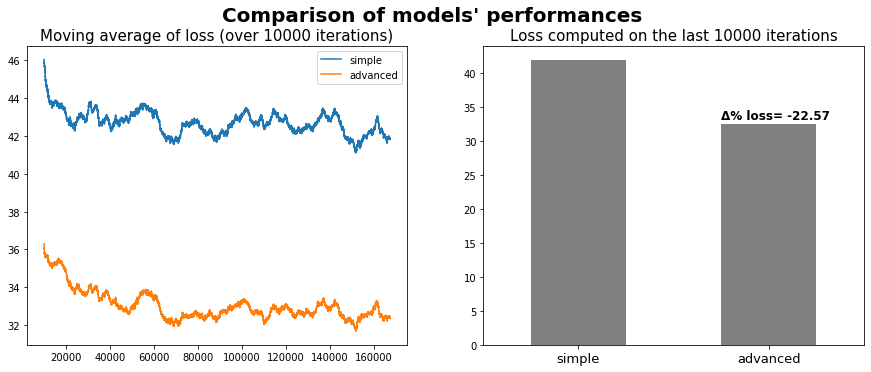

In [35]:
loss_type = 1 # 1 for L1-loss, 2 for L2-loss
n_iter = 10_000 # Number of iterations on which to compute the loss (for moving average and final value)

df_loss = (pd.concat([error, error_advanced], axis=1, keys=["simple", "advanced"])
           .apply(lambda x: np.power(np.abs(x), loss_type)))

f, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5.5))
f.suptitle("Comparison of models' performances", fontweight=SUPTITLE_FONTWEIGHT, fontsize=SUPTITLE_FONTSIZE)

df_loss.rolling(n_iter).mean().plot(ax=ax1)
ax1.set_title(f"Moving average of loss (over {n_iter} iterations)", fontsize=15)

loss_last_it = df_loss.tail(n_iter).mean()
pct_diff_loss = 100 * (loss_last_it.advanced / loss_last_it.simple - 1)

loss_last_it.plot.bar(ax=ax2, color="gray")
ax2.set_title(f"Loss computed on the last {n_iter} iterations", fontsize=15)
ax2.text(.75, loss_last_it.advanced * 1.025, f"Δ% loss= {pct_diff_loss:.2f}", fontsize=12, fontweight=SUPTITLE_FONTWEIGHT)
ax2.set_xticklabels(ax2.get_xticklabels(), fontsize=13, rotation=0)

plt.show()

The model with interactions and log-transformed target offers a substantial improvement over the simple model: the **loss** (computed on the last 10 000 observations) **decrease by about 23%**.